# Social Media Analytics Assignment 2
## MSBA Spring 2018
### Ryan Conklin, Reed Dalton, Gihani Dissanayake, Ali Prasla, Jake Schmidt
<br>
<br>

In [1]:
import glob, pandas as pd
data = [{
  'date': pd.to_datetime(filename.split(' ')[0].lstrip('speeches/').strip('\\')),
  'speaker': filename.rstrip('.txt').split(' ', 1)[1],
  'text': open(filename, 'rb').readline().decode('cp1252')
} for filename in glob.glob('speeches/*.txt')]
speeches = pd.DataFrame(data)
speeches = speeches.set_index(['speaker', 'date'])
speeches.head()

text
speaker           date                                                         
George Washington 1789-04-30  Fellow Citizens of the Senate and the House of...
                  1789-10-03  Whereas it is the duty of all Nations to ackno...
                  1790-01-08  Fellow Citizens of the Senate and House of Rep...
                  1790-12-08  Fellow citizens of the Senate and House of Rep...
                  1790-12-29  I the President of the United States by my own...

# Task A
## Choose a reasonable number of topics for this corpus. One way to think about topics is to consider the number of issues that may have been important in the past as well as those that may have come up over the centuries. Provide a brief explanation of how you chose this number.

To evaluate a reasonable number of topics, we cross validated the LDA of Part B with 10, 15, 20, and 25 components/topics, the outputs are shown in the plots below. 10 topics seemed too few as the first two topics carried an unreaonably high proportion of the of the 633 speeches. Conversely, 25 components seemed to be too many, as the last 10 or so topics were highly sparse and seemed superfluous. A more ideal combination of topics is with 15 or 20 topics, at which the spreadof speeches appears more reasonably distrubted. Since they appear comparable in performance, we choose to go with the simpler option of 15 topics.

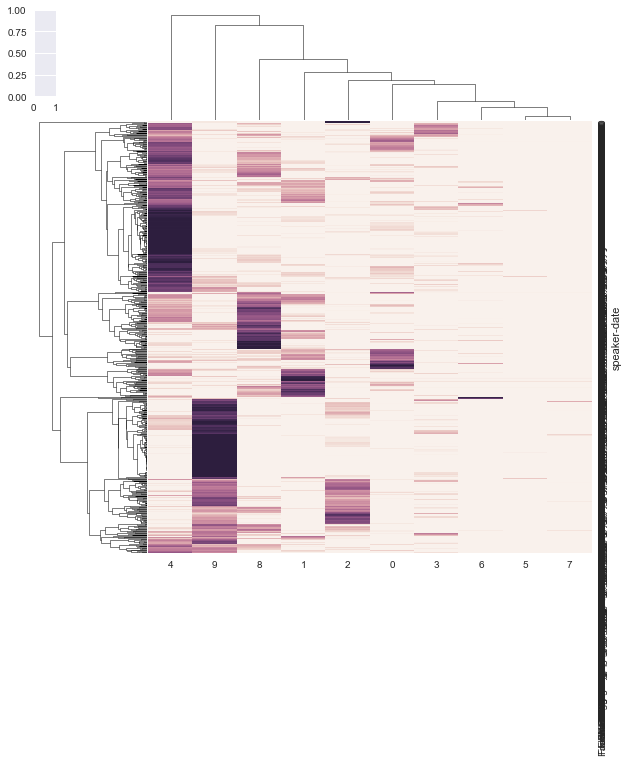

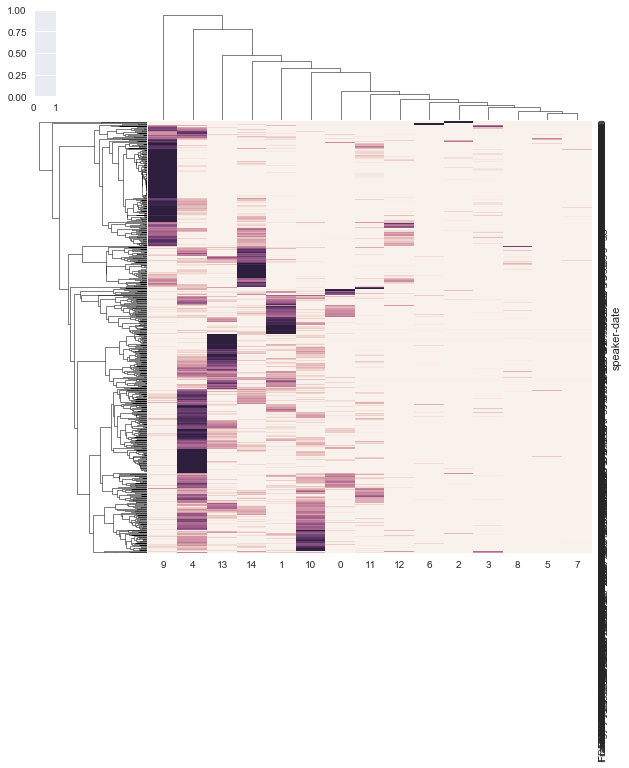

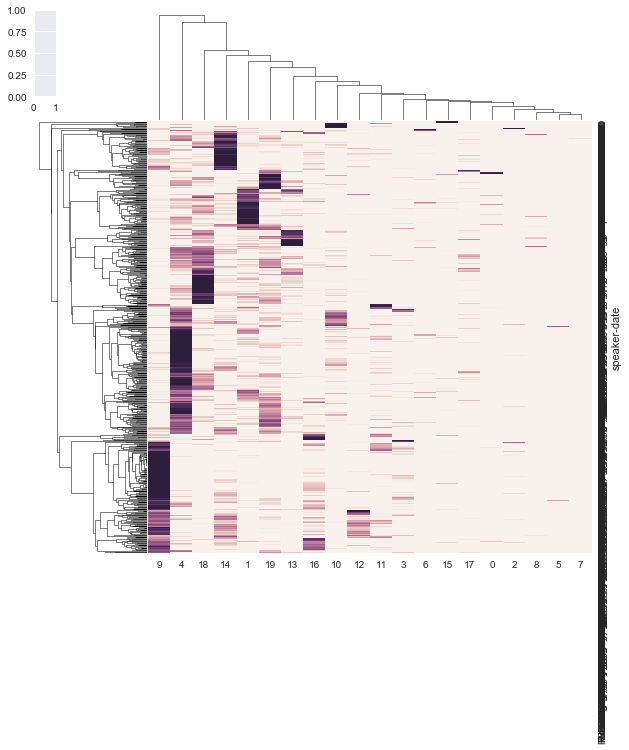

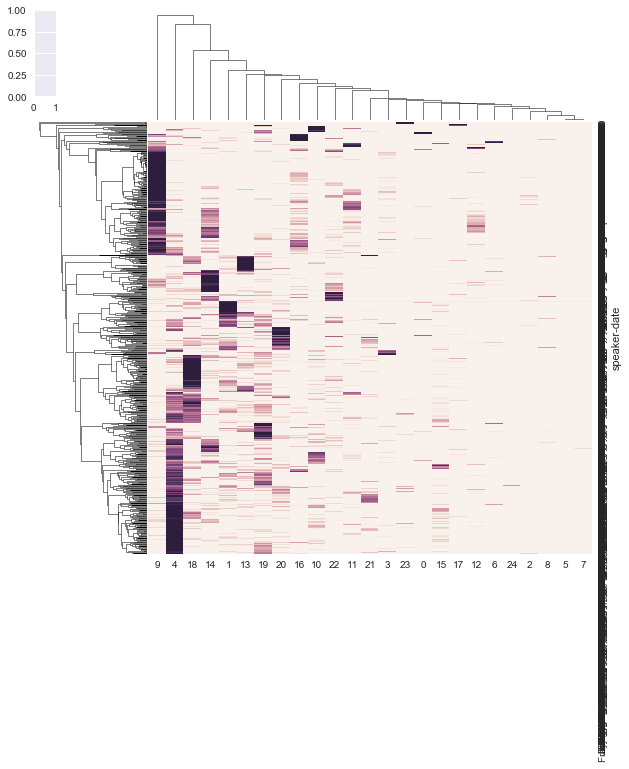

In [2]:
from IPython.display import display, Image
display(Image(filename='components10.png'))
display(Image(filename='components15.png'))
display(Image(filename='components20.png'))
display(Image(filename='components25.png'))

In [3]:
N_TOPICS = 15

# Task B
## Now perform a topic modeling exercise with LDA. Show the word distributions for each topic as well as topic distributions for each speech. Do you see any shifts over time? Explain.

In [4]:
from sklearn.decomposition import LatentDirichletAllocation as LDA
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import make_pipeline
pipe = make_pipeline(
  CountVectorizer(stop_words='english'),
  LDA(n_components=N_TOPICS, learning_method='batch', n_jobs=-1, max_iter=25, random_state=42)
)
speech_topic = pipe.fit_transform(speeches.text)

In [5]:
import numpy as np
n_words = 10
vocab = pipe.steps[0][1].get_feature_names()
topic_words = {}
for topic, comp in enumerate(pipe.steps[1][1].components_):   
    word_idx = np.argsort(comp)[::-1][:n_words]
    # store the words most relevant to the topic
    topic_words[topic] = [vocab[i] for i in word_idx]
pd.DataFrame(topic_words).T

,0,1,2,3,4,5,6,7,8,9
0,law,negro,vote,rights,alabama,congress,right,president,negroes,church
1,president,mr,think,people,going,time,say,believe,don,want
2,slavery,constitution,states,missouri,united,territory,court,kansas,shall,compromise
3,germany,german,conference,great,poland,people,government,united,state,states
4,world,peace,people,nation,united,nations,war,freedom,new,great
5,beloved,press,cherokees,gun,newspaper,boats,agent,remonstrance,news,information
6,lebanon,israel,country,middle,schedule,army,men,tariff,east,union
7,bank,act,banks,stock,stockholders,power,notes,privileges,necessary,constitution
8,government,work,relief,industry,workers,people,prices,program,farm,want
9,states,government,united,public,congress,great,country,citizens,state,people


Each row above is a topic number, and the columns represent the most important 10 words mentioned in presidential speeches for each of those topics. Though there are some overlap e.g. "president" in the top thee words of topics 0 and 1, there are clear differences between the top 10 words of each topic, indicating that the topics themselves are fairly different. This supports the number of topics we selected as well as the methodology we used.

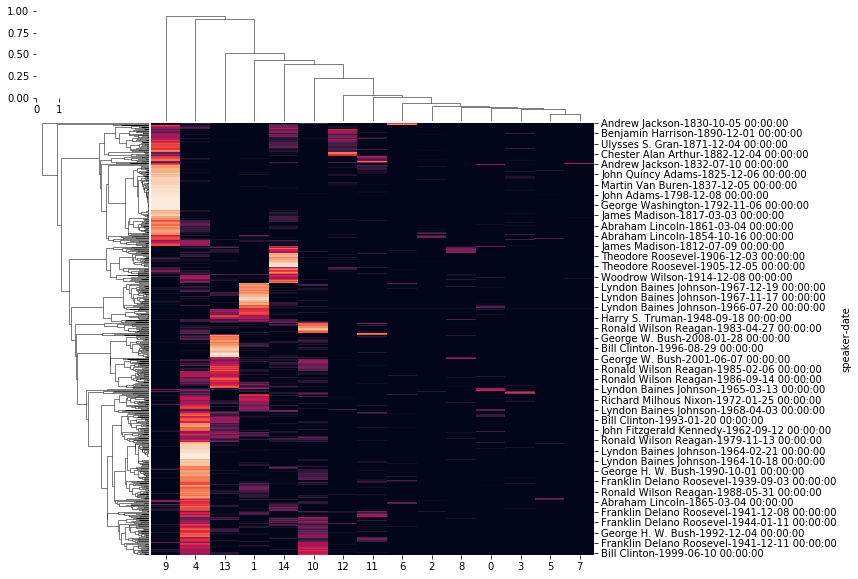

In [6]:
import matplotlib.pyplot as plt, seaborn as sns
x = pd.DataFrame(pipe.transform(speeches.text), index=speeches.index)
sns.clustermap(x, cbar=False)
plt.show()

This Cluster Map shows how topics change over time. Presidents of similiar eras have similar topics they like to discuss. For example, Topic Four is mostly associated with the 20th century presidents (with a heavy emphasis on JFK and Nixon). The top words within in this topic (Nam, Government, and Soviet among others) grant credence to this premise.

# Task C
## In terms of topics addressed “heavily” in a speech, which 3 former presidents does President Trump share the highest similarity with? How did you arrive at your conclusion?

In [7]:
from sklearn.metrics.pairwise import cosine_similarity
xx = x.reset_index(1, True)
mean_topic_per_prez = xx.groupby(xx.index).mean()
similarity = pd.DataFrame(cosine_similarity(mean_topic_per_prez),index = mean_topic_per_prez.index)
similarity.columns = list(mean_topic_per_prez.index)
similarity.loc['Donald Trump'].sort_values(ascending = False)[1:4]

Barack Obama    0.841988
Bill Clinton    0.778533
Jimmy Carter    0.711390
Name: Donald Trump, dtype: float64

Trump is the most similar to Barack Obama, Bill Clinton, and Jimmy Carter. We arrived at this conclusion by averaging the topic vectors for all speeches and then conducting a cosine similarity with the averaged vectors.

# Task D
## In terms of his own speeches, do you see President Trump shifting the emphasis on certain topics over time? Explain your response.

In [8]:
index = speeches.index
with_topics = pd.concat([speeches.reset_index(drop = True),pd.DataFrame(speech_topic)],axis = 1)
with_topics.index = index
trump_speeches = with_topics.reset_index(inplace = False)
trump_speeches = trump_speeches[trump_speeches.speaker == 'Donald Trump'].sort_values('date')
trump_speeches['Max_Topic'] = np.argmax(trump_speeches[list(range(N_TOPICS))].as_matrix(),axis = 1)
trump_speeches[['date','Max_Topic']]

,date,Max_Topic
625,2015-06-15,1
627,2016-09-16,1
628,2016-11-09,13
629,2017-01-20,1
630,2017-07-25,13
631,2017-07-25,13
632,2018-01-30,1


Trump does not seem to change topics over time. Above we looked at the most important topic for each speech and there is no clear trend away from Topic One. Interestingly enough, Topic One is perhaps the most uninterpretable and incoherent topic in our data set (which aligns with our priors for the President).

# Task E

## If you do a K-means clustering with the same number of clusters as topics, do you see President Trump’s speeches and those of the 3 former presidents you identified in Task C in the same cluster? What was the basis of clustering (e.g., tf-idf, cosine similarity, etc.). Discuss your findings.

In [9]:
from sklearn.cluster import KMeans
q = mean_topic_per_prez
model = KMeans(n_clusters=15, n_jobs=-1, max_iter=25, random_state=42)
model.fit(q) # fit the model

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=25,
    n_clusters=15, n_init=10, n_jobs=-1, precompute_distances='auto',
    random_state=42, tol=0.0001, verbose=0)

In [21]:
kmeans_clusters = pd.DataFrame(q.index, index=None)
kmeans_clusters['cluster'] = model.labels_
kmeans_clusters.sort_values(['cluster'])
#sorts the presidents by their cluster, the index is the alphabetical order of presidents by first name

,speaker,cluster
21,James Knox Polk,0
39,William Henry Harrison,0
36,Thomas Jefferson,0
31,Millard Fillmore,0
30,Martin Van Buren,0
28,John Tyler,0
27,John Quincy Adams,0
25,John Adams,0
23,James Monroe,0
22,James Madison,0


In [22]:
#trump is alone in his cluser
kmeans_clusters[kmeans_clusters['cluster'] == 10]

,speaker,cluster
8,Donald Trump,10


In [23]:
#distribution of presidents per cluster
kmeans_clusters['cluster'].value_counts()

0     15
1      4
9      3
8      3
7      3
6      3
14     2
12     2
4      2
3      2
13     1
11     1
10     1
5      1
2      1
Name: cluster, dtype: int64

This method of k-means clustering takes the mean topic score vector for each president, and divides them into 15 clusters, the same number of topics we chose earlier. As shown above, this puts Donald Trump in his own cluster, cluster #10. This cluster is not alone in having one president within it, as clusters 13, 11, 5, and 2 also contain exactly 1 president.

Given the 15 clusters and 15 topics, we can see below that it is not surprising that Trump appears in his own cluster. If you look to topic 1 below (not to be confused with cluster 1) the only strong presense there is Trump, and he has a very weak presense in virtually every other topic. This pattern is not similar to any of the other presidents, which is why he appears in his own cluster when there are 15 clusters. All of this implies that a more optimal number of k-means clusters is less than 15. 

Cosine similarity is a better predictor of similarity between presidents than k-means clustering, as it creates a hierarchy of closeness between vectors in a single dimension. It is also does not need cross-validation to optimize, while the accuracy of k-means depends on having the proper number of clusters. 

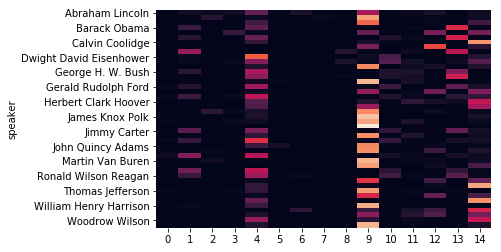

In [13]:
sns.heatmap(q, cbar=False)
plt.show()

# Task F

## Provide a visualization of both clusters (with colors) and cosine scores using MDS. 

In [14]:
from sklearn import manifold

In [15]:
#below we create the cosine scores using MDS from the sklearn package with 2 components

mds = manifold.MDS(n_components=2, max_iter=3000, eps=1e-9, random_state=42, n_jobs=-1)
pos = mds.fit_transform(similarity)

C:\Users\HP-\Anaconda3\lib\site-packages\sklearn\manifold\mds.py:407: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.
  warnings.warn("The MDS API has changed. ``fit`` now constructs an"


In [16]:
#Here we add the cosine scores to our cluster dataframe for visualization purposes
col1 = []
col2 = []
for i, v in enumerate(pos):
    col1.append(v[0]); col2.append(v[1])
kmeans_clusters["Xpos"] = col1
kmeans_clusters["Ypos"] = col2

In [17]:
kmeans_clusters.head()

,speaker,cluster,Xpos,Ypos
0,Abraham Lincoln,12,-0.039431,1.221177
1,Andrew Jackson,0,-1.007094,2.041116
2,Andrew Johnson,12,-1.051175,1.461831
3,Barack Obama,8,2.764600,-1.117696
4,Benjamin Harrison,9,-1.495292,-0.137632


In [18]:
import colorlover as cl
from IPython.display import HTML
#color lover will help us visualize the clusters with different colors, the paired scale works well for qualitative/categorical

bupu = cl.scales['11']['qual']['Paired']
bupu500 = cl.interp( bupu, 15)[0:15] # Map color scale to 15 bins
#here match each unique cluster with a color and zip into a dictionary
levels = []
for i in kmeans_clusters['cluster'].unique():
    levels.append(i)
levels
color_match = dict(zip(levels, bupu500))

In [19]:
import plotly
import plotly.plotly as py
import plotly.graph_objs as go
#for each row/president create a new marker with x and y coordinates being the cosine MDS scores 
#match the cluster with a specific color and add in cluster # and president name as text
data = []
for index,row in kmeans_clusters.iterrows():
    mark = go.Scatter(x=row['Xpos'], y=row['Ypos'],
                mode='markers',
                marker=dict(
                    size='12',
                    color = color_match[row['cluster']]),
                text= "Cluster:"+ " "+str(row['cluster']),
                    name= row['speaker'],
                     showlegend=False)
    data.append(mark)

#plot each of the points
layout = go.Layout(xaxis=dict(zeroline=False, showgrid=False,
                              ticks='', showticklabels=False),
                   yaxis=dict(zeroline=False, showgrid=False,
                              ticks='', showticklabels=False),
                   height=900, hovermode='closest')
fig = go.Figure(data=data, layout=layout)

py.iplot(fig)

If you are not running plotly and colorlover, check below for embedded link


https://plot.ly/~rdc033/33.embed